In [1]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import sklearn.cluster as skclust 
import copy

def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int(i/int(row[2]) - 1)
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_ind_fitnesses(filename,obj):
    with open(filename) as file:
        csv_data = csv.reader(file,delimiter=',')
        lines = []
        for row in csv_data:
            for i in range(3,int(row[1])+3):
                lines.append([int(row[0]),i-3,float(row[i])])
    return lines

def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(state == 1):
                nbr_param = int(row[0])
                state = 2
            elif(state == 2):
                nbr_param += int(row[0])
                state = 3
            elif(state == 3 and i < nbr_param):
                i+=1
            elif(state == 3 and i >= nbr_param):
                lines.append([coord[0],coord[1],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of joints","number of sensors","fitness"])
                
def load_number_of_eval_per_gen(foldername,nbr_gen):
    nbr_eval_per_gen = [0]*nbr_gen
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            nbr_eval = 0
            for row in csv_data:
                if(len(row) == 4):
                    nbr_eval+=1
        nbr_eval_per_gen[gen] += nbr_eval
   # for i in range(1,len(nbr_eval_per_gen)):
    #    nbr_eval_per_gen[i] += nbr_eval_per_gen[i-1]
    return nbr_eval_per_gen
    
def load_controllers_fitnesses(foldername,nbr_gen):
    best_fits = [[] for _ in range(nbr_gen)]
    learn_prog = [[] for _ in range(nbr_gen)]
    learn_delta = [[] for _ in range(nbr_gen)]
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            best_fit = 0
            init_fit = 0
            counter = 0
            for row in csv_data:
                if(len(row) == 2):
                    if(init_fit == 0):
                        init_fit = float(row[0])
                        if(init_fit < 0):
                            init_fit = 0.5
                    if(best_fit < float(row[0])):
                        best_fit = float(row[0])
                    counter+=1
            learn_prog[gen].append((best_fit - init_fit))
            learn_delta[gen].append((best_fit - init_fit)/counter)
            best_fits[gen].append(best_fit)
        
    return best_fits, learn_delta, learn_prog    
    
    
def load_descriptor(filename,desc_size) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(desc_size+2) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return np.array(descriptors)
    
def sparsness_per_gen(descriptors,pop_size):
    sparsness = []
    for i in range(int(len(descriptors)/pop_size)):
        tmp_desc = descriptors[i*pop_size:(i+1)*pop_size]
        spars = 0
        for o in range(len(tmp_desc)):
            for p in range(len(tmp_desc)):
                if(o==p):
                    continue
                dist = np.linalg.norm(np.array(tmp_desc[o][3:])-np.array(tmp_desc[p][3:]))
            spars += dist
        sparsness.append([i,spars/10])
    return sparsness

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

def plot_hist_nbr_rob(title,data,organ,bins,nb_rob):
    fig = plt.gcf()
    fig.set_size_inches(25,10)
    ax = sns.histplot(data=data,multiple="stack",bins=bins,x='gen',hue=organ,palette="light:b")
    ax.set_ylabel("Number of robots",fontsize=20)
    ax.set_xlabel("Generations",fontsize=20)
    plt.title(title,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(range(1,nb_rob+1),labels=[1]*nb_rob,fontsize=20)
    plt.show()

In [154]:
organ_lines = []
nb_eval_lines = []

In [155]:
arena="Amphitheatre"

In [141]:
exp_folder = "/home/leni/are-logs/mnipes_steps_frontier/wa/100/"

In [103]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne in nbr_eval:
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])

    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    
    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_c_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

20
22760
20
32850
20
22990
20
23820
20
21540


In [104]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [105]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","100"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","100"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","100"])

2000


In [156]:
exp_folder = "/home/leni/are-logs/mnipes_steps_tcds/wa/200/"

In [157]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"with archive 200",ne])
            break
      
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*4000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

20
29600
20
39020
20
38930
20
38800
20
56090
20
50960
20
33570
20
67420
20
62060
20
49990


In [52]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [53]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors",arena])

4000


In [158]:
exp_folder = "/home/leni/are-logs/mnipes_steps_tcds/na/200/"

In [159]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"no archive 200",ne])
            break
            
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,ne,np.mean(lp),np.max(lp)])
na_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

20
39500
20
38880
20
77900
20
51370
20
55730
20
39870
20
46900
20
50190
20
47090
20
44620


(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 9 Text yticklabel objects>)

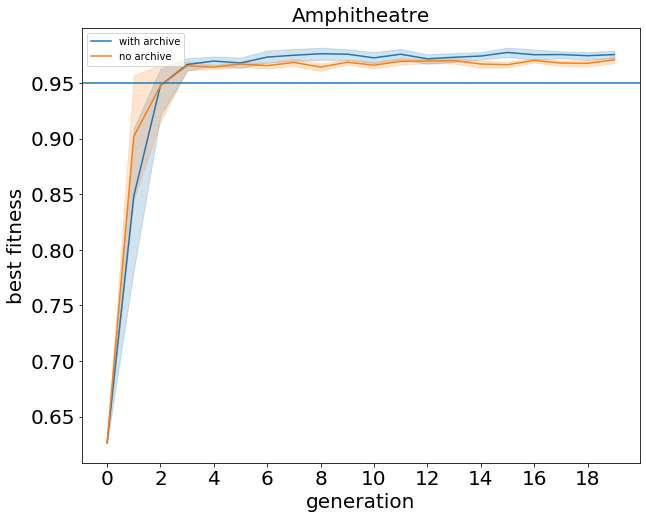

In [123]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="best fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 9 Text yticklabel objects>)

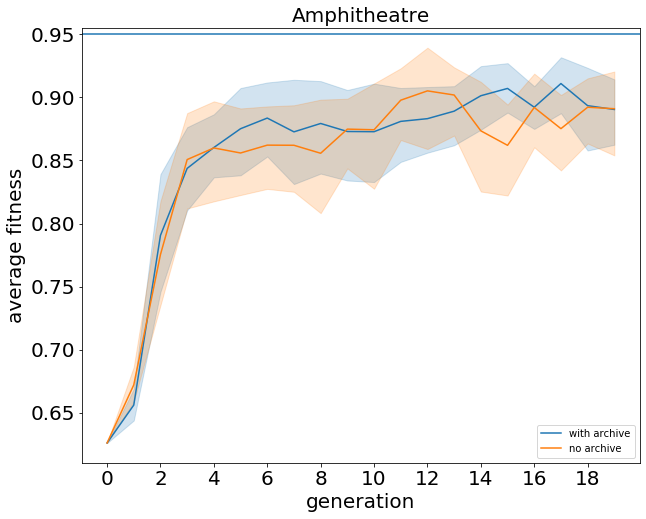

In [115]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 <a list of 8 Text yticklabel objects>)

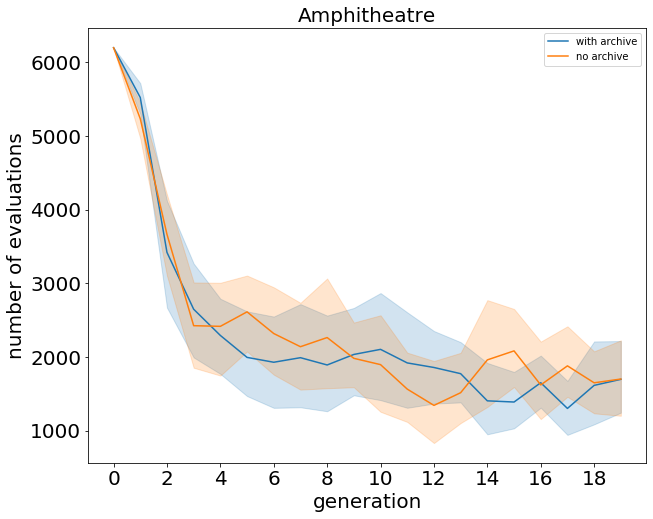

In [116]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


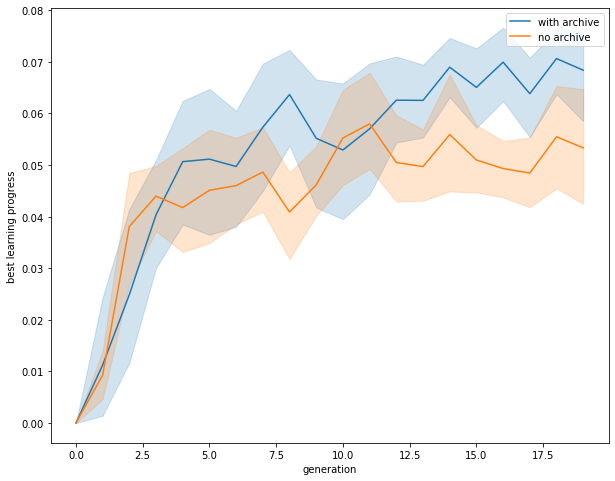

In [117]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="no archive")

(array([-0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ]),
 <a list of 8 Text yticklabel objects>)

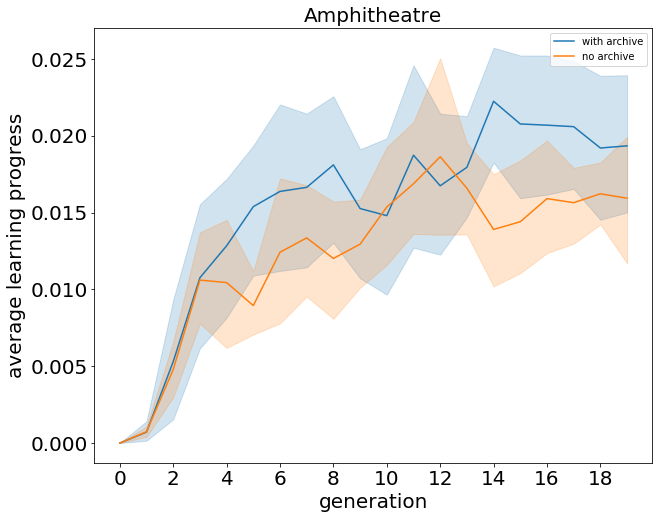

In [118]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="average learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average learning progress",label="no archive")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

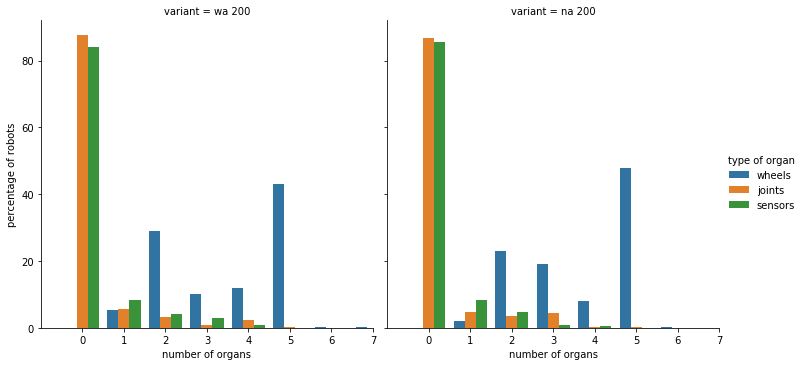

In [121]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

In [160]:
exp_folder = "/home/leni/are-logs/mnipes_steps_tcds/wa/150/"

In [161]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"with archive 150",ne])
            break
            
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*3000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_cc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

30
29780
30
41730
30
60610
30
26730
30
57420


In [126]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [127]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","wa 150"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","wa 150"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","wa 150"])

3000


In [162]:
exp_folder = "/home/leni/are-logs/mnipes_steps_tcds/na/150/"

In [163]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"no archive 150",ne])
            break
            
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,ne,np.mean(lp),np.max(lp)])
na_cc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

30
39360
30
37520
30
38110
30
57650
30
51480


(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
 <a list of 10 Text yticklabel objects>)

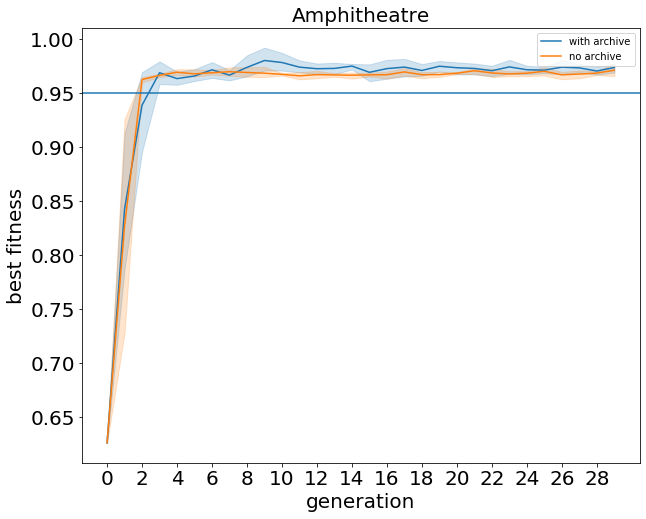

In [138]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="best fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 9 Text yticklabel objects>)

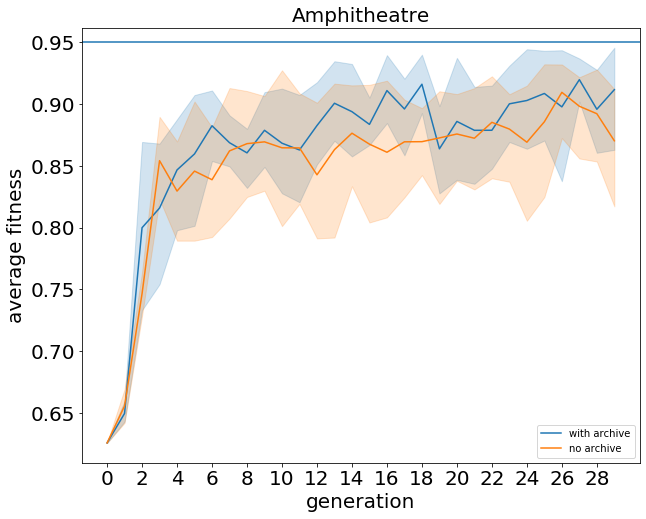

In [139]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 8 Text yticklabel objects>)

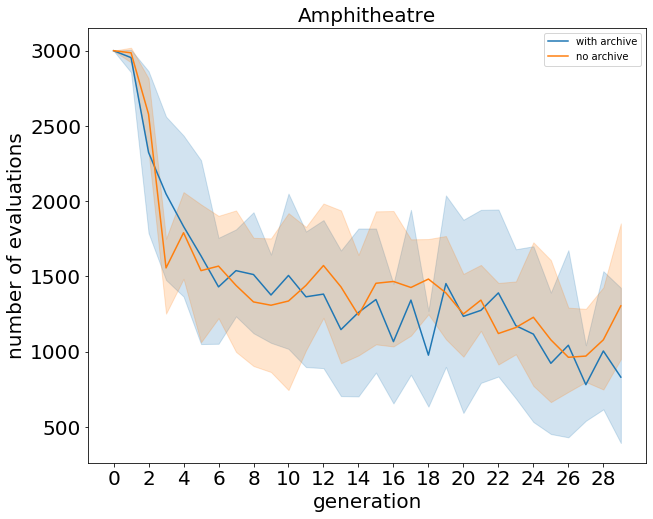

In [140]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


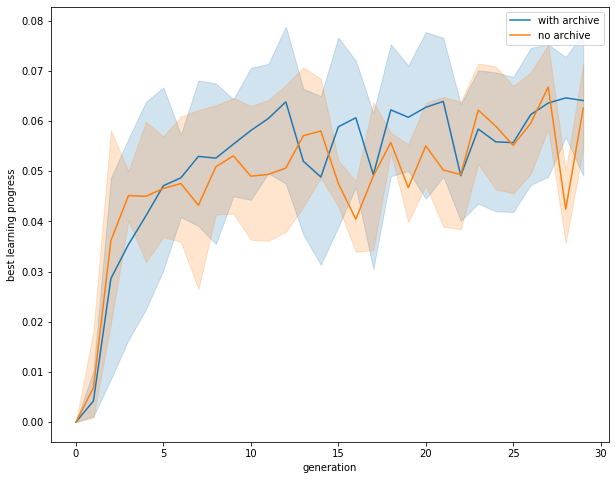

In [141]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best learning progress",label="no archive")

(array([-0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,
         0.035]),
 <a list of 9 Text yticklabel objects>)

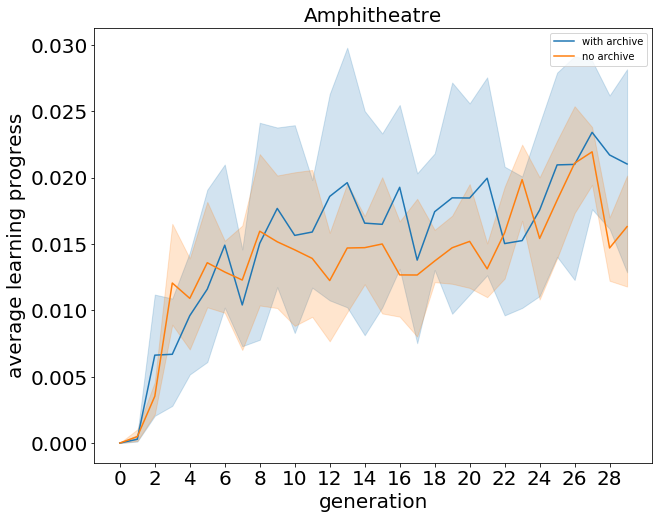

In [142]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="average learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average learning progress",label="no archive")
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

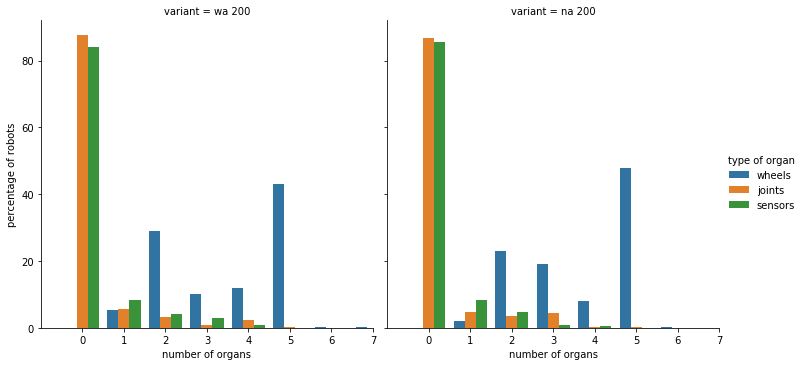

In [121]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

In [ ]:
arena="Two Paths"

In [ ]:
exp_folder = "/home/leni/are-logs/mnipes_paths_tcds/wa/200/"

In [ ]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"200",acc_nbr_eval[-1]])
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*4000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

In [35]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [36]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors",arena])

2380


In [73]:
exp_folder = "/home/leni/are-logs/mnipes_paths_tcds/na/200/"

In [ ]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"200",acc_nbr_eval[-1]])

    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,ne,np.mean(lp),np.max(lp)])
na_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

In [216]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [217]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 9 Text yticklabel objects>)

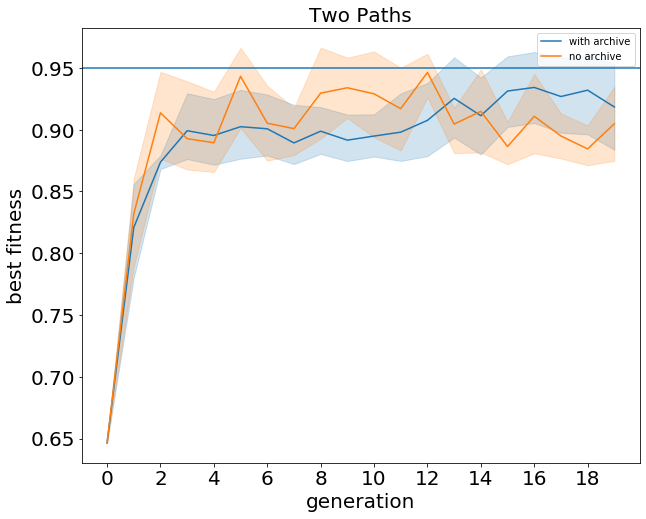

In [75]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="best fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 9 Text yticklabel objects>)

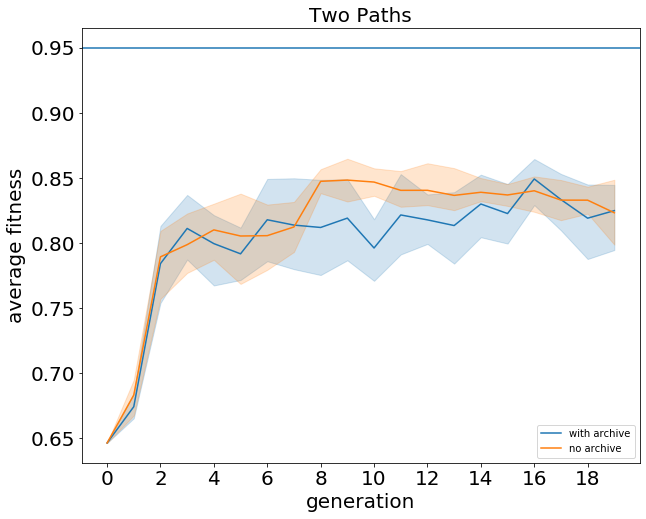

In [76]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([3000., 3500., 4000., 4500., 5000., 5500., 6000., 6500.]),
 <a list of 8 Text yticklabel objects>)

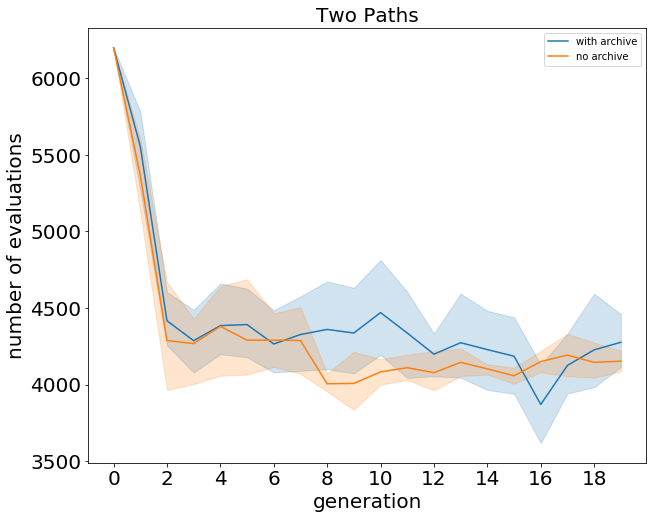

In [77]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

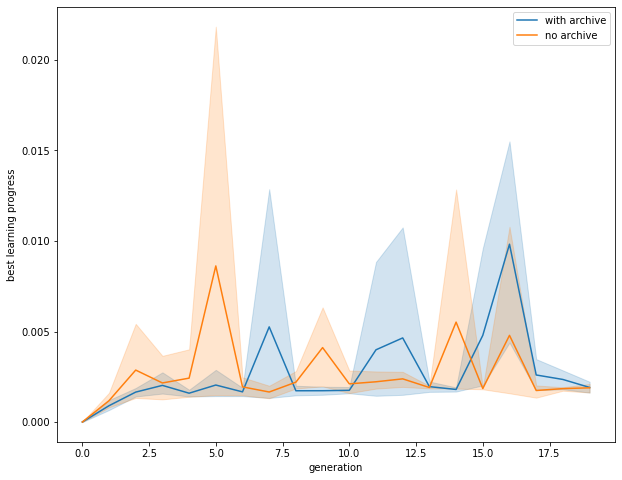

In [221]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="no archive")

(array([-0.00025,  0.     ,  0.00025,  0.0005 ,  0.00075,  0.001  ,
         0.00125,  0.0015 ,  0.00175,  0.002  ,  0.00225]),
 <a list of 11 Text yticklabel objects>)

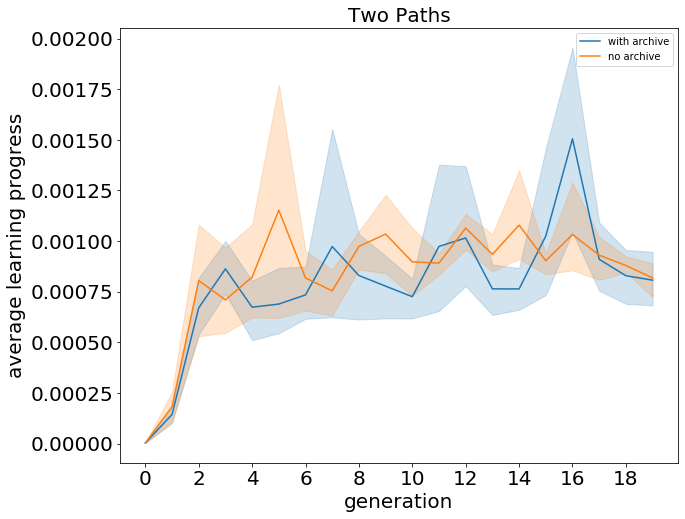

In [78]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="average learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average learning progress",label="no archive")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

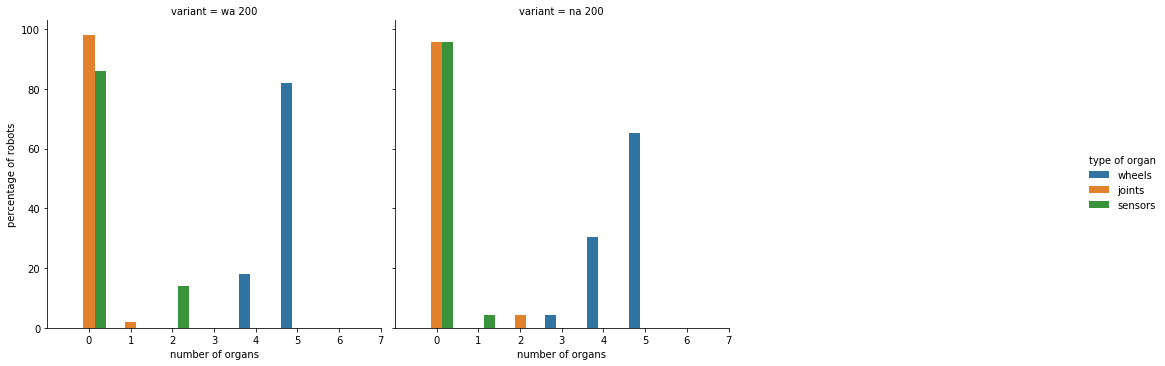

In [223]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=3)
g.set(xlim=[-1,7])

In [164]:
arena = "Hard Race"

In [165]:
exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/wa/200/"

In [166]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"with archive 200",ne])
            break
            
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*4000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

20
82290
20
83370
20
63390
20
70950
20
69230
20
78160
20
81370
20
80730
20
75720
20
75850


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 8 Text yticklabel objects>)

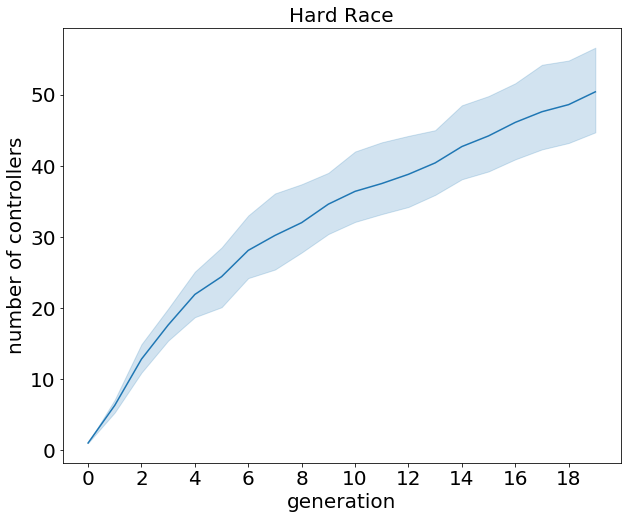

In [72]:
fig = plt.gcf()
fig.set_size_inches(10,8)
ax = sns.lineplot(data=wa_dc_data,x="generation",y="number of controllers")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [57]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [58]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors",arena])

4000


In [167]:
exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/na/200/"

In [168]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"no archive 200",acc_nbr_eval[-1]])
            break

    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,ne,np.mean(lp),np.max(lp)])
na_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

20
41330
20
37990
20
66090
20
29050
20
37140
20
20760
20
34660
20
20150
20
24350
20
29390


In [96]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [97]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


(array([0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 6 Text yticklabel objects>)

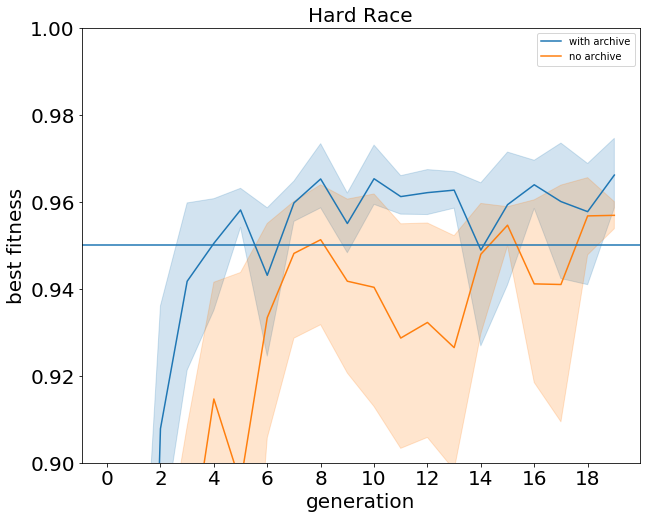

In [104]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="best fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best fitness",label="no archive")
ax.axhline([0.95])
ax.set_ylim([0.9,1])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 9 Text yticklabel objects>)

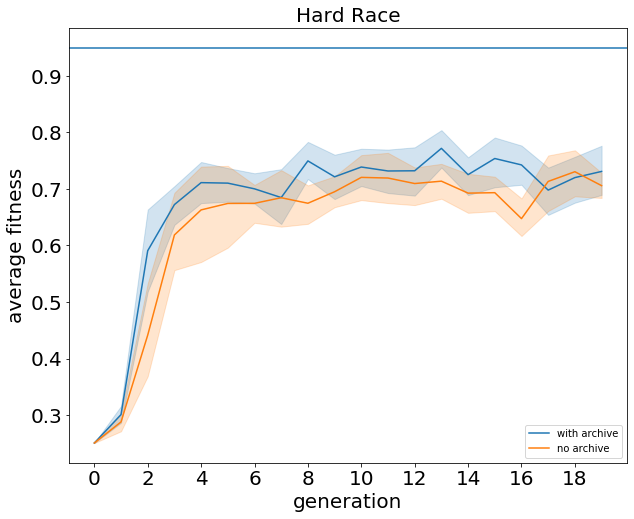

In [99]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([2500., 3000., 3500., 4000., 4500., 5000., 5500., 6000., 6500.]),
 <a list of 9 Text yticklabel objects>)

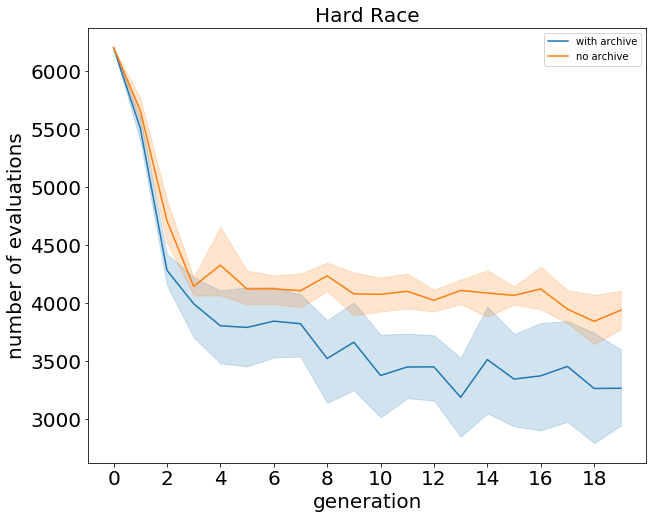

In [100]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

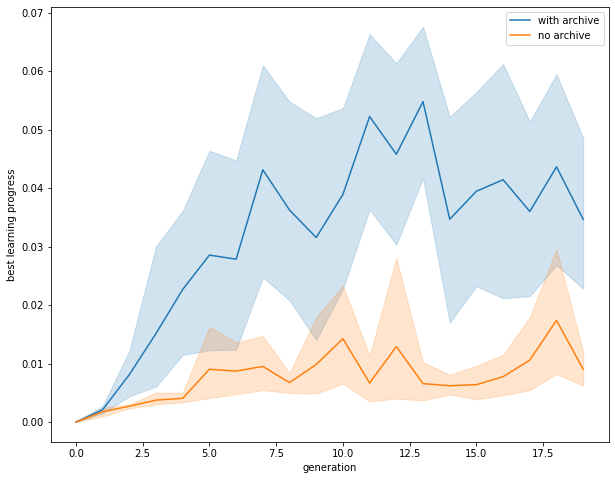

In [101]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="no archive")

(array([-0.002,  0.   ,  0.002,  0.004,  0.006,  0.008,  0.01 ,  0.012,
         0.014]),
 <a list of 9 Text yticklabel objects>)

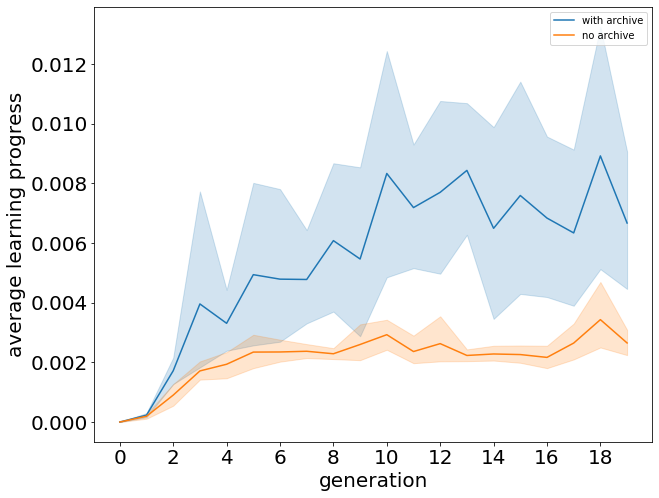

In [102]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="average learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average learning progress",label="no archive")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

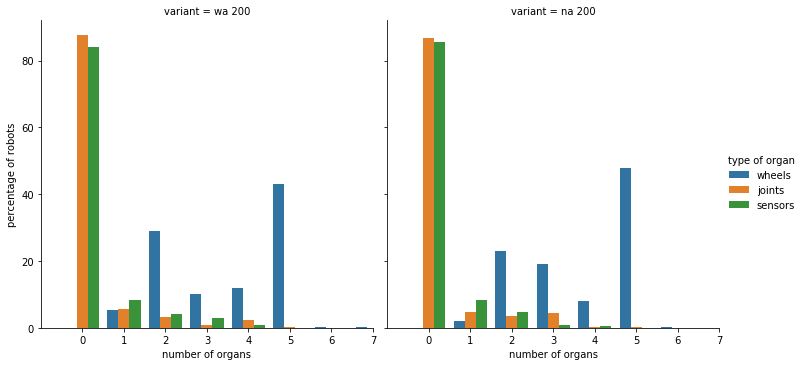

In [120]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

In [169]:
exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/wa/150/"

In [170]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"with archive 150",ne])
            break 
            
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*4000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_cc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

30
76790
30
87090
30
84200
30
84980
30
87350
30
64290
30
73800
30
70950
30
85440


In [92]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [93]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","wa 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","wa 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","wa 200"])

4000


In [171]:
exp_folder = "/home/leni/are-logs/mnipes_hard_tcds/na/150/"

In [172]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"no archive 150",ne])
            break

    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,ne,np.mean(lp),np.max(lp)])
na_cc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

30
87440
30
85690
30
89130
30
88530


In [96]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [97]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 <a list of 10 Text yticklabel objects>)

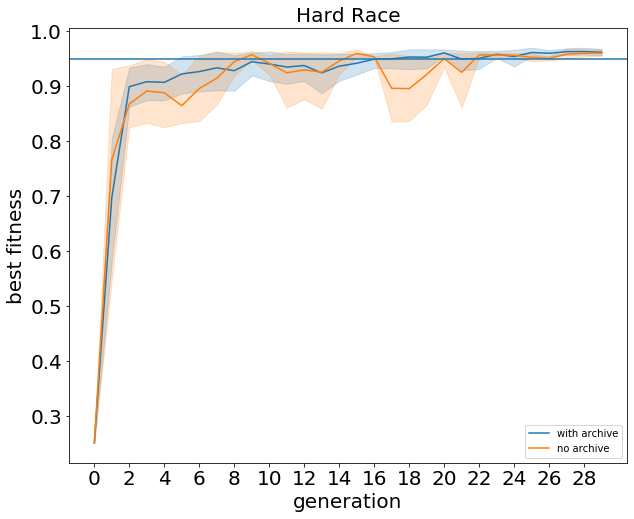

In [7]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="best fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 9 Text yticklabel objects>)

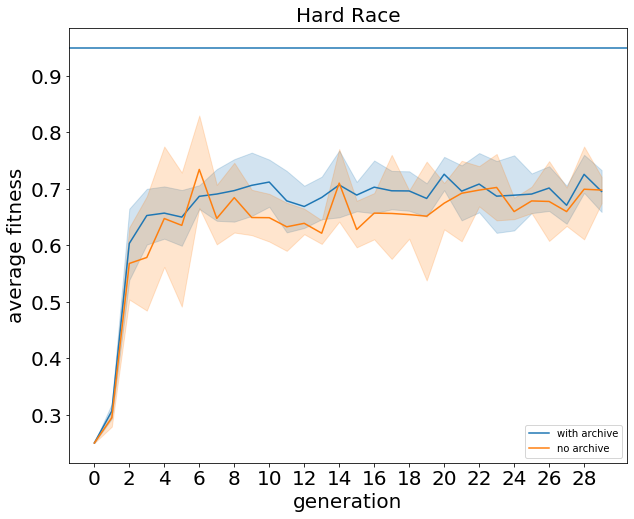

In [9]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([2000., 2200., 2400., 2600., 2800., 3000., 3200.]),
 <a list of 7 Text yticklabel objects>)

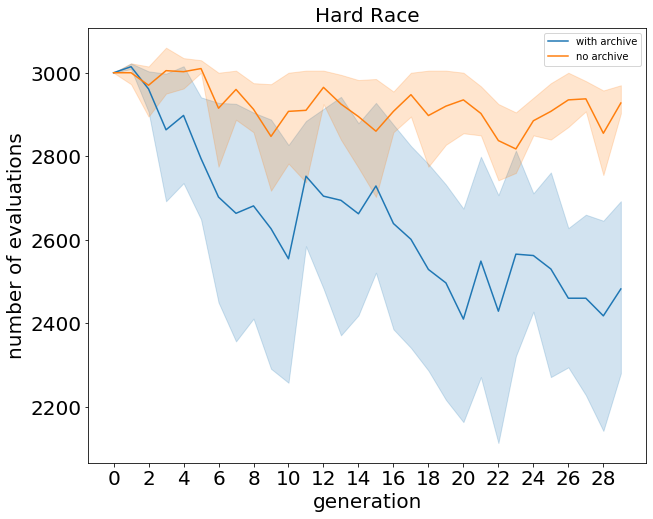

In [10]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

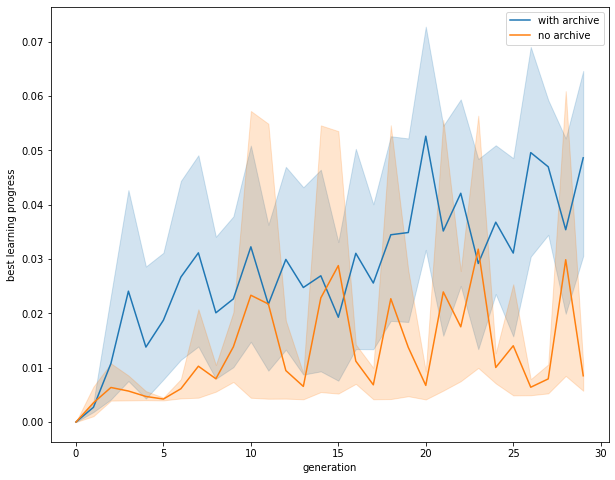

In [11]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best learning progress",label="no archive")

(array([-0.002,  0.   ,  0.002,  0.004,  0.006,  0.008,  0.01 ,  0.012,
         0.014]),
 <a list of 9 Text yticklabel objects>)

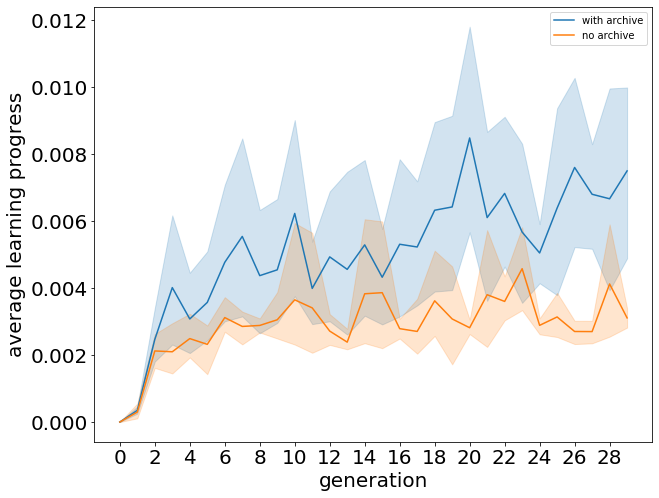

In [13]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="average learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average learning progress",label="no archive")
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [173]:
arena = "Two Rooms"

In [174]:
exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/wa/200/"

In [175]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"with archive 200",ne])
            break
            
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*4000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

20
82820
20
76210
20
88550
20
63950
20
82400
20
69230
20
81470
20
80360
20
76510
20
79780


In [62]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [63]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels",arena])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints",arena])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors",arena])

4000


In [176]:
exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/na/200/"

In [177]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"no archive 200",ne])
            break
            
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,ne,np.mean(lp),np.max(lp)])
na_dc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

20
82100
20
90170
20
85240
20
83190
20
84260
20
87110
20
82750
20
83440
20
89890
20
84550


In [9]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [10]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


(array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), <a list of 6 Text yticklabel objects>)

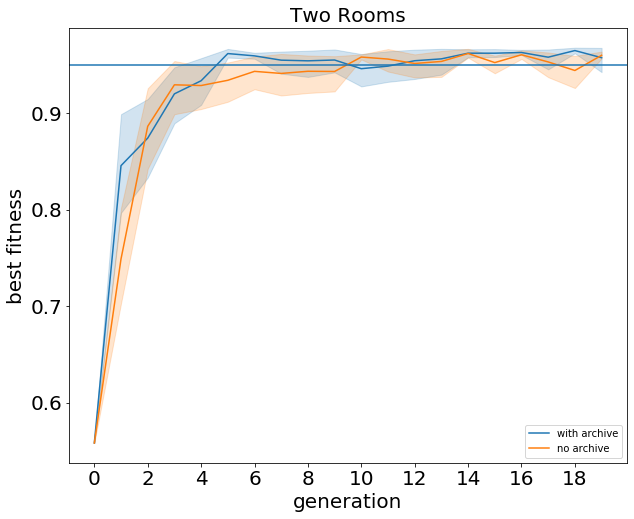

In [58]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="best fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 11 Text yticklabel objects>)

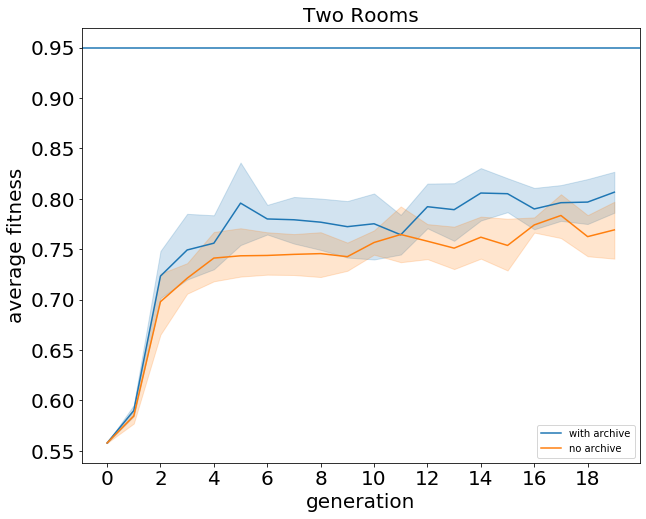

In [59]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_dc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([2500., 3000., 3500., 4000., 4500., 5000., 5500., 6000., 6500.]),
 <a list of 9 Text yticklabel objects>)

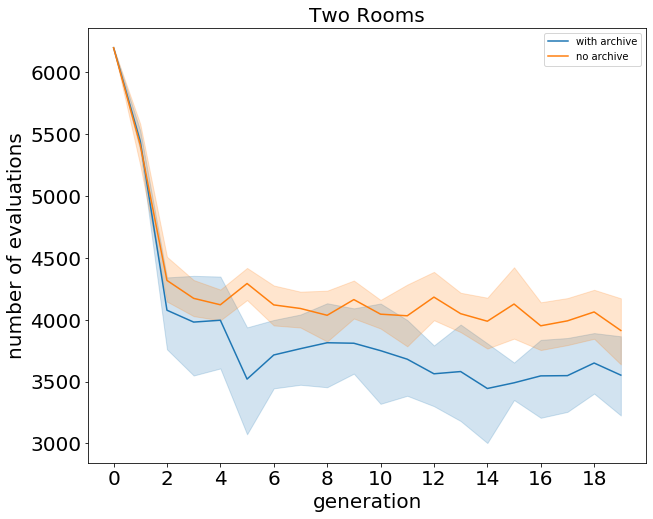

In [60]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xticks(range(0,20,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,
         0.035,  0.04 ,  0.045]),
 <a list of 11 Text yticklabel objects>)

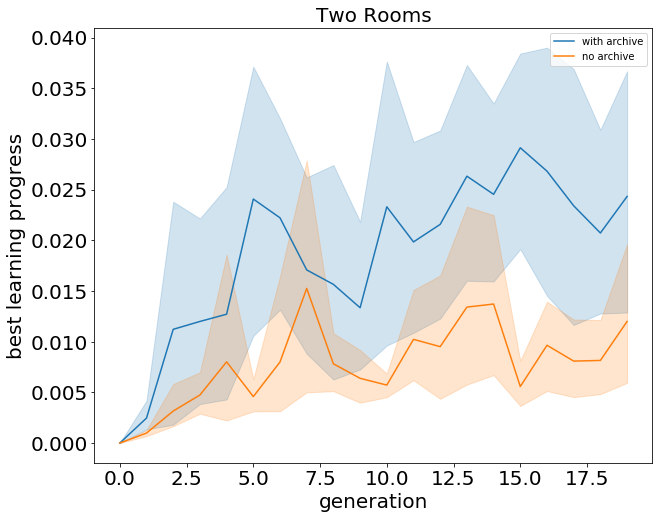

In [50]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="best learning progress",label="no archive")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-0.001,  0.   ,  0.001,  0.002,  0.003,  0.004,  0.005,  0.006,
         0.007]),
 <a list of 9 Text yticklabel objects>)

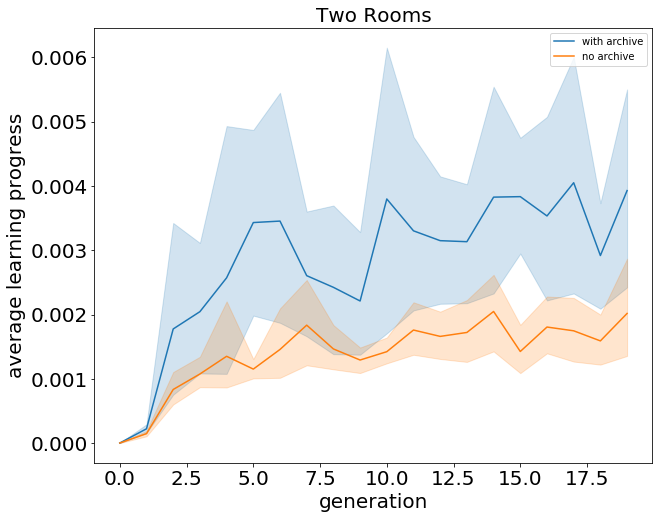

In [51]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_dc_data,x="generation",y="average learning progress",label="with archive")
ax = sns.lineplot(data=na_dc_data,x="generation",y="average learning progress",label="no archive")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [52]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

ValueError: min() arg is an empty sequence

In [178]:
exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/wa/150/"

In [179]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"with archive 150",ne])
            break
            
    nbr_ctrl_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        for i,line in ctrl_arch.iterrows():
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af, nc,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*4000,bf,af,ane,nc,ne,np.mean(lp),np.max(lp)])
wa_cc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of controllers","number of evaluations","average learning progress","best learning progress"])

30
87210
30
75460
30
76630
30
85730
30
79970
30
82620
30
86740
30
81240


In [16]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [6]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","wa 150"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","wa 150"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","wa 150"])

4000


In [180]:
exp_folder = "/home/leni/are-logs/mnipes_rooms_tcds/na/150/"

In [181]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    acc_nbr_eval = [0]
    for ne,fit in zip(nbr_eval,best_fit):
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            nb_eval_lines.append([arena,"no archive 150",ne])
            break

    print(acc_nbr_eval[-1])
    best_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))

    for gen, bf, af,ane,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,acc_nbr_eval,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,ane,ne,np.mean(lp),np.max(lp)])
na_cc_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","evaluations","number of evaluations","average learning progress","best learning progress"])

30
87720
30
88240
30
82680
30
84850
30
87500
30
86930
30
88160
30
84360
30
86590
30
87870


In [9]:
lines = []
for folder in os.listdir(exp_folder):
    lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
fit_data = pd.DataFrame(data=lines,columns=["generation","individual","fitness"])

In [10]:
lines = []
sparsness = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv",8)
    sparsness += sparsness_per_gen(descriptors,20)
    for desc in descriptors:
        lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
seg_sparsness_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
morph_data = pd.DataFrame(data=lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","na 200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","na 200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","na 200"])


(array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), <a list of 6 Text yticklabel objects>)

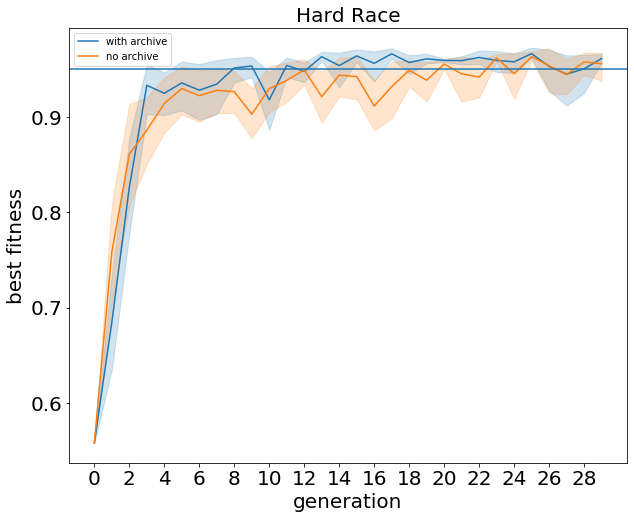

In [19]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="best fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


(array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 11 Text yticklabel objects>)

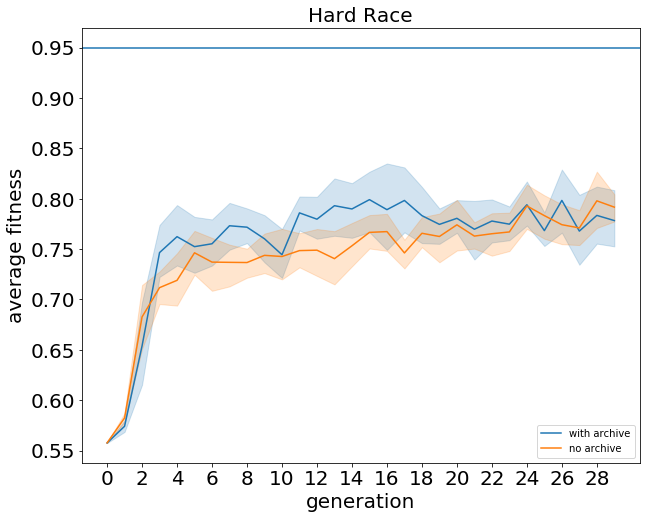

In [20]:
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.lineplot(data=wa_cc_data,x="generation",y="average fitness",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average fitness",label="no archive")
ax.axhline([0.95])
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([2000., 2200., 2400., 2600., 2800., 3000., 3200.]),
 <a list of 7 Text yticklabel objects>)

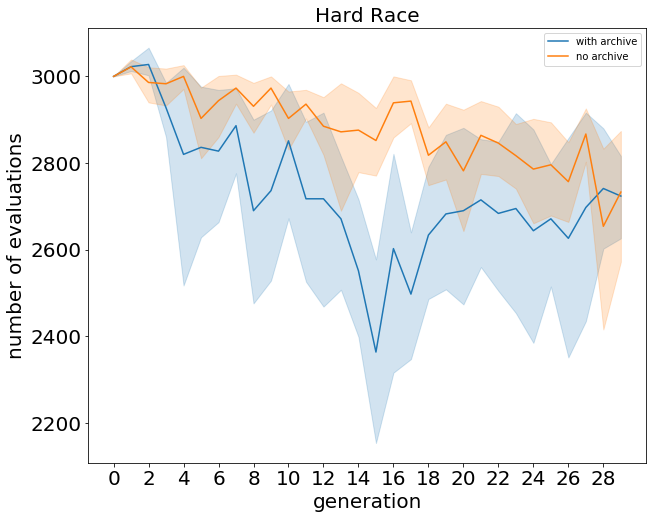

In [21]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="number of evaluations",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="number of evaluations",label="no archive")
ax.set_xticks(range(0,30,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06]),
 <a list of 8 Text yticklabel objects>)

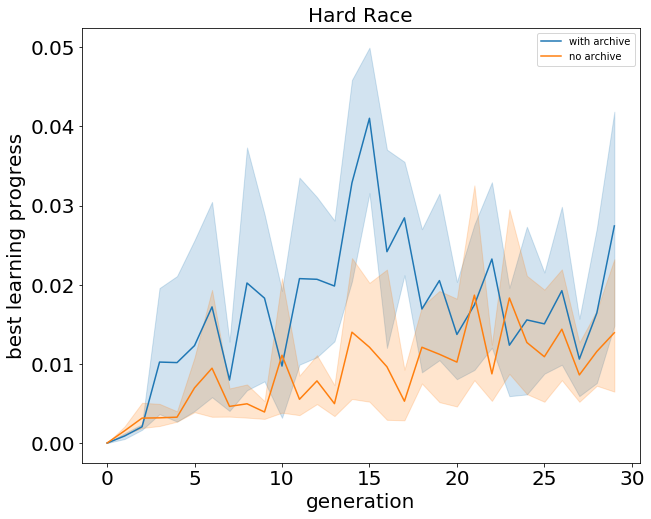

In [22]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="best learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="best learning progress",label="no archive")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-0.002,  0.   ,  0.002,  0.004,  0.006,  0.008,  0.01 ]),
 <a list of 7 Text yticklabel objects>)

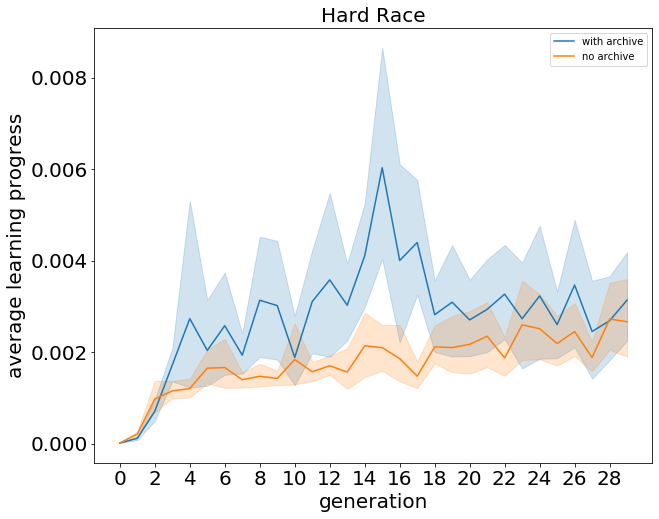

In [24]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.lineplot(data=wa_cc_data,x="generation",y="average learning progress",label="with archive")
ax = sns.lineplot(data=na_cc_data,x="generation",y="average learning progress",label="no archive")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xticks(range(0,30,2))
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

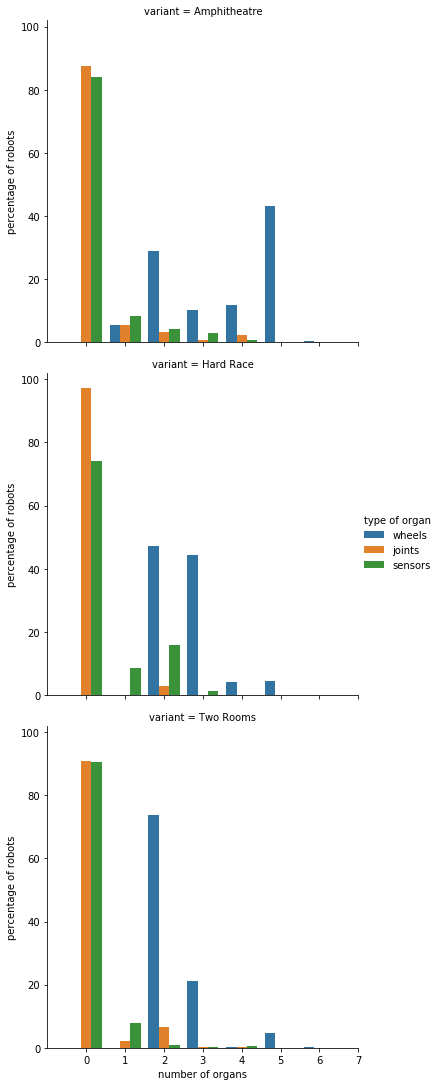

In [66]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=1)
g.set(xlim=[-1,7])

      environment           variant  number of evaluations
0    Amphitheatre  with archive 200                   6200
1    Amphitheatre  with archive 200                   6200
2    Amphitheatre  with archive 200                   6200
3    Amphitheatre  with archive 200                  11800
4    Amphitheatre  with archive 200                  11980
..            ...               ...                    ...
96      Two Rooms    no archive 150                  15200
97      Two Rooms    no archive 150                   9020
98      Two Rooms    no archive 150                  21100
99      Two Rooms    no archive 150                   6000
100     Two Rooms    no archive 150                   6030

[101 rows x 3 columns]


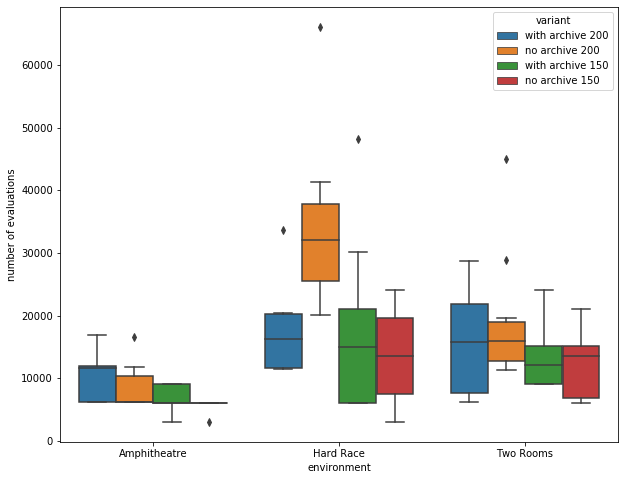

In [185]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
nb_eval_data = pd.DataFrame(data=nb_eval_lines,columns=["environment","variant","number of evaluations"])
print(nb_eval_data)
ax = sns.boxplot(data=nb_eval_data,x="environment",y="number of evaluations",hue="variant")